In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import math
import json
from statistics import mean, median

import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import scipy.io as sio
from tqdm import trange

from datasubset import DataSubset
import models.MNIST_improved_ia
import models.MNIST_naive_ia
from pgd_attack import LinfPGDAttack

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#################
# Configuration #
#################

with open('config.json') as config_file:
    config = json.load(config_file)

# Setting up training parameters
tf.set_random_seed(config['random_seed'])

# Training parameters
model_dir = config['model_dir']
max_num_training_steps = config['max_num_training_steps']
num_output_steps = config['num_output_steps']
num_summary_steps = config['num_summary_steps']
num_checkpoint_steps = config['num_checkpoint_steps']
num_eval_steps = config['num_eval_steps']
batch_size = config['training_batch_size']
w_l1 = config["w_l1"]
w_rsloss = config["w_rsloss"]

num_train_samples = 55000
num_valid_samples = 5000
num_test_samples = 10000
batch_size = 128

In [3]:
# Run this *before* loading the model here interactively because we won't be able
# to release the GPU memory later on
!python post_process_model.py --model_dir $model_dir --output temporary --do_eval

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please switch to 

In [4]:
#############
# Load data #
#############

mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

natural_images = {
    "train": mnist.train.images,
    "valid": mnist.validation.images,
    "test": mnist.test.images
}

y = {
    "train": mnist.train.labels,
    "valid": mnist.validation.labels,
    "test": mnist.test.labels
}

assert(len(natural_images["train"]) == num_train_samples == len(y["train"]))
assert(len(natural_images["valid"]) == num_valid_samples == len(y["valid"]))
assert(len(natural_images["test"]) == num_test_samples == len(y["test"]))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
####################
# Initialise model #
####################

if config["estimation_method"] == 'improved_ia':
    model = models.MNIST_improved_ia.Model(config)
elif config["estimation_method"] == 'naive_ia':
    model = models.MNIST_naive_ia.Model(config)
else:
    print("Defaulting to Naive IA for ReLU bound estimation")
    model = models.MNIST_naive_ia.Model(config)

sess = tf.Session()

checkpoint = tf.train.latest_checkpoint(model_dir)
saver = tf.train.Saver()
saver.restore(sess, checkpoint)

INFO:tensorflow:Restoring parameters from trained_models/mnist_improved_ia_0.2/checkpoint-125000


In [6]:
###############################
# Generate adversarial images #
###############################

# We need to generate examples to attack both the natural model
# and the adversarial model

# Attacking the natural model
attack = LinfPGDAttack(model, 
                       config['epsilon'],
                       config['k'],
                       config['a'],
                       config['random_start'],
                       config['loss_func'],
                       config['incremental'])

def generate_adversarial_images(X, y):
    num_batches = int(math.ceil(len(X) / batch_size))
    X_adv = [] # Accumulator

    for i in range(num_batches):
        bstart = i * batch_size
        bend = min(bstart + batch_size, len(X))

        x_batch = X[bstart:bend, :]
        y_batch = y[bstart:bend]

        x_batch_adv = attack.perturb(x_batch, y_batch, sess)
        X_adv.append(x_batch_adv)
    
    return np.concatenate(X_adv)

# A 2-dimensional dict indexed by (model being attacked, dataset)
adversarial_images = {
    "valid": generate_adversarial_images(natural_images["valid"], y["valid"]),
    "test":  generate_adversarial_images(natural_images["test"], y["test"])
}

In [7]:
################################
# Generate model hidden layers #
################################

def generate_hidden_layers(input_images):
    num_batches = int(math.ceil(len(input_images) / batch_size))
    hidden_layers = [] # Accumulator
    
    for i in range(num_batches):
        bstart = i * batch_size
        bend = min(bstart + batch_size, len(input_images))
        
        x_batch = input_images[bstart:bend, :]
        feed_dict = {model.x_input: x_batch}

        hidden_layer_batch = sess.run(model.last_hidden_layer, feed_dict=feed_dict)
        hidden_layers.append(hidden_layer_batch)
    
    return np.concatenate(hidden_layers, axis=0)

# A 3-dimensional dict indexed by (model outputing hidden layers, type of attack, dataset)
hidden_layers = {
    "nat": {
        "train": generate_hidden_layers(natural_images["train"]),
        "valid": generate_hidden_layers(natural_images["valid"]),
        "test":  generate_hidden_layers(natural_images["test"])
    },
    "adv": {
        "valid": generate_hidden_layers(adversarial_images["valid"]),
        "test":  generate_hidden_layers(adversarial_images["test"])
    }
}

In [8]:
##############################
# Generate model predictions #
##############################

def generate_predictions(input_images):
    num_batches = int(math.ceil(len(input_images) / batch_size))
    hidden_layers = [] # Accumulator
    
    for i in range(num_batches):
        bstart = i * batch_size
        bend = min(bstart + batch_size, len(input_images))
        
        x_batch = input_images[bstart:bend, :]
        feed_dict = {model.x_input: x_batch}

        hidden_layer_batch = sess.run(model.y_pred, feed_dict=feed_dict)
        hidden_layers.append(hidden_layer_batch)
    
    return np.concatenate(hidden_layers, axis=0)

# A 3-dimensional dict indexed by (model outputing hidden layers, type of attack, dataset)
predictions = {
    "nat": {
        "train": generate_predictions(natural_images["train"]),
        "valid": generate_predictions(natural_images["valid"]),
        "test":  generate_predictions(natural_images["test"])
    },
    "adv": {
        "valid": generate_predictions(adversarial_images["valid"]),
        "test":  generate_predictions(adversarial_images["test"])
    }
}

In [9]:
class SVMModel():
    def __init__(self, X_train, y_train, kernel="linear", decision_function_shape="ovo", cache_size=1024):
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        self.svm = SVC(kernel=kernel, decision_function_shape=decision_function_shape, cache_size=cache_size)
        self.svm.fit(X_train_scaled, y_train)

    def predict(self, X):
        return self.svm.predict(self.scaler.transform(X))
    
    def predict_with_adversarial_prediction(self, X, adv_prediction_function):
        """Uses the `adv_prediction_function` to decide if the input is
           adversarial; if so, outputs class -1. Otherwise, outputs the
           predicted class."""
        y_predict = self.predict(X)
        class_distances = self.get_predicted_class_decision_boundary_distances(X, y_predict)
        y_predict_is_adv = np.fromiter(map(adv_prediction_function, class_distances), dtype=np.bool)
        
        for i, x in enumerate(y_predict_is_adv):
            if x:
                y_predict[i] = -1
        
        return y_predict

    def get_decision_boundary_distances(self, X):
        return self.svm.decision_function(self.scaler.transform(X))

    def get_predicted_class_decision_boundary_distances(self, X, predictions, num_classes=10):
        distances = self.get_decision_boundary_distances(X)

        predicted_class_distances = []

        for k in range(len(X)):
            distances_for_k = distances[k]
            predicted_class_distances_for_k = []
            i = predictions[k]
            # When j < i
            for j in range(i):
                index = int((num_classes - 0.5) * j - math.pow(j, 2) / 2 + (i - j - 1))
                predicted_class_distances_for_k.append(-1 * distances_for_k[index])
            # When i < j
            base_index = int((num_classes - 0.5) * i - math.pow(i, 2) / 2)
            for j in range(i + 1, num_classes):
                index = base_index + (j - i - 1)
                predicted_class_distances_for_k.append(distances_for_k[index])
            predicted_class_distances.append(predicted_class_distances_for_k)

        return predicted_class_distances

    def test(self, X_test, y_test):
        """Calculates the accuracy of the model on some test data, without
           adversarial prediction."""
        
        return self.svm.score(self.scaler.transform(X_test), y_test)

    def test_with_adversarial_prediction(self, X_test, y_test, is_adversarial, adv_prediction_function):
        """Calculates the accuracy of the model on some test data when using
           adversarial prediction. Takes a boolean flag indicating if the test
           data is adversarial or not, and an adversarial prediction function"""
        
        y_predict = self.predict_with_adversarial_prediction(X_test, adv_prediction_function)
        
        # Number of inputs with correct class predicted
        num_correct = np.sum(y_predict == y_test)
        
        if is_adversarial:
            # If the examples are adversarial it's also correct to predict the
            # class -1 (which indicates adversarialness)
            num_correct += np.sum(y_predict == -1)
                        
        return num_correct / len(X_test)
    
    def distances_linear_map(self, X):
        start = 0
        end = 0
        class_support_vect = []

        class_dual_coef = []
        for k in self.svm.n_support_:
            end += k
            class_support_vect.append(self.svm.support_vectors_[start:end])
            class_dual_coef.append(self.svm.dual_coef_[:, start:end])
            start = end

        dists = np.zeros((45,100))
        k = 0
        for i in range(10):        
            for j in range(i+1, 10):
                dists[k] += np.sum(class_dual_coef[i][j-1].reshape(1,-1).T * class_support_vect[i], axis=0)
                dists[k] += np.sum(class_dual_coef[j][i].reshape(1,-1).T * class_support_vect[j], axis=0)
                k += 1

        return ((dists / self.scaler.scale_).T, self.svm.intercept_ - ((dists / self.scaler.scale_) @ self.scaler.mean_))

In [10]:
svm_model = SVMModel(hidden_layers["nat"]["train"], y["train"])

/data/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


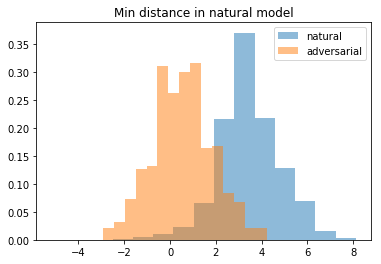

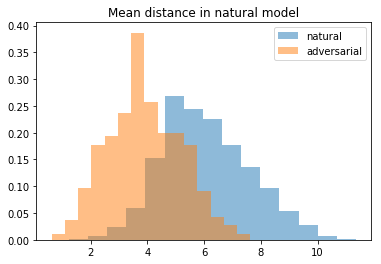

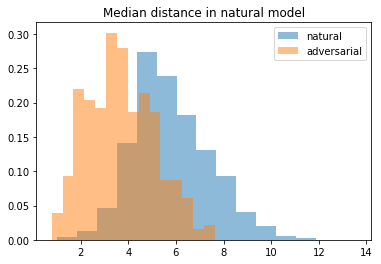

In [11]:
valid_nat_dists = svm_model.get_predicted_class_decision_boundary_distances(
                             hidden_layers["nat"]["valid"],
                             predictions["nat"]["valid"])

valid_adv_dists = svm_model.get_predicted_class_decision_boundary_distances(
                             *zip(*[(x,y) for (x,y,z) in  zip(
                                 hidden_layers["adv"]["valid"],
                                 predictions["adv"]["valid"],
                                 y["valid"]
                             ) if y != z])
                         )

nat_min_dists = list(map(lambda xs: min(xs), valid_nat_dists))
adv_min_dists = list(map(lambda xs: min(xs), valid_adv_dists))

nat_mean_dists = list(map(lambda xs: mean(xs), valid_nat_dists))
adv_mean_dists = list(map(lambda xs: mean(xs), valid_adv_dists))

nat_median_dists = list(map(lambda xs: median(xs), valid_nat_dists))
adv_median_dists = list(map(lambda xs: median(xs), valid_adv_dists))

plt.title("Min distance in natural model")
plt.hist(nat_min_dists, normed=True, bins=15, alpha=0.5, label="natural")
plt.hist(adv_min_dists, normed=True, bins=15, alpha=0.5, label="adversarial")
plt.legend()
plt.show()

plt.title("Mean distance in natural model")
plt.hist(nat_mean_dists, normed=True, bins=15, alpha=0.5, label="natural")
plt.hist(adv_mean_dists, normed=True, bins=15, alpha=0.5, label="adversarial")
plt.legend()
plt.show()

plt.title("Median distance in natural model")
plt.hist(nat_median_dists, normed=True, bins=15, alpha=0.5, label="natural")
plt.hist(adv_median_dists, normed=True, bins=15, alpha=0.5, label="adversarial")
plt.legend()
plt.show()

## Validation accuracy

In [12]:
def calculate_accuracy(hidden_layers, predictions, y, is_adv, adv_pred_function):
    dists = svm_model.get_predicted_class_decision_boundary_distances(
                                 hidden_layers,
                                 predictions)
        
    if not is_adv:
        correct_predict = [not adv_pred_function(xs) and a == b
                           for (xs,a,b) in zip(dists, predictions, y)]
    else:
        correct_predict = [adv_pred_function(xs) or a == b
                           for (xs,a,b) in zip(dists, predictions, y)]
    
    return np.sum(correct_predict) / len(hidden_layers)

adv_pred_function = lambda xs: min(xs) < 2.0

print(calculate_accuracy(hidden_layers["nat"]["valid"],
                         predictions["nat"]["valid"],
                         y["valid"],
                         False,
                         adv_pred_function),
      "accuracy on natural images")


print(calculate_accuracy(hidden_layers["adv"]["valid"],
                         predictions["adv"]["valid"],
                         y["valid"],
                         True,
                         adv_pred_function),
      "accuracy on adversarial images")

0.8946 accuracy on natural images
0.9896 accuracy on adversarial images


## Test accuracy

In [13]:
adv_pred_function = lambda xs: min(xs) < 2.0

print(calculate_accuracy(hidden_layers["nat"]["test"],
                         predictions["nat"]["test"],
                         y["test"],
                         False,
                         adv_pred_function),
      "accuracy on natural images")


print(calculate_accuracy(hidden_layers["adv"]["test"],
                         predictions["adv"]["test"],
                         y["test"],
                         True,
                         adv_pred_function),
      "accuracy on adversarial images")

0.8949 accuracy on natural images
0.9903 accuracy on adversarial images


## Add an SVM-distances to the fully-connected final layer

In [14]:
svm_dist_W, svm_dist_b = svm_model.distances_linear_map(hidden_layers["nat"]["valid"])

x_single_train = natural_images["test"][0:1, :]
y_single_train = y["test"][0:1]
dict_nat_single = { model.x_input: x_single_train,
                    model.x_input_natural: x_single_train,
                    model.y_input: y_single_train }

sm_v = [x for x in tf.global_variables() if x.op.name=='Variable_6'][0]
sm_b = [x for x in tf.global_variables() if x.op.name=='Variable_7'][0]

# Save values in the final variables
sm, smb = sess.run([sm_v, sm_b], feed_dict = dict_nat_single)

modified_W = np.concatenate((sm, svm_dist_W), axis=1)
modified_b = np.concatenate((smb, svm_dist_b))

model.output_layer_with_dists = tf.matmul(model.last_hidden_layer,
                                          tf.constant(modified_W, dtype=tf.float32)) +\
                                tf.constant(modified_b, dtype=tf.float32)

## Test the new final layer

Verify that the modified layer predicts the correct class and distance outputs, to within a tolerance.

In [15]:
def generate_outputs(input_images):
    num_batches = int(math.ceil(len(input_images) / batch_size))
    all_class_outputs = [] # Accumulator
    all_dist_outputs = [] # Accumulator
    
    for i in range(num_batches):
        bstart = i * batch_size
        bend = min(bstart + batch_size, len(input_images))
        
        x_batch = input_images[bstart:bend, :]
        feed_dict = {model.x_input: x_batch}

        output_batch = sess.run(model.output_layer_with_dists, feed_dict=feed_dict)
        class_outputs = output_batch[:, :10]
        dist_outputs = output_batch[:, 10:]
        
        all_class_outputs.append(class_outputs)
        all_dist_outputs.append(dist_outputs)
    
    return (np.concatenate(all_class_outputs, axis=0),
            np.concatenate(all_dist_outputs, axis=0))

outputs = {
    "nat": {
        "train": generate_outputs(natural_images["train"]),
        "valid": generate_outputs(natural_images["valid"]),
        "test":  generate_outputs(natural_images["test"])
    },
    "adv": {
        "valid": generate_outputs(adversarial_images["valid"]),
        "test":  generate_outputs(adversarial_images["test"])
    }
}

epsilon = 0.0001

for (a,b,c,d) in zip(*outputs["nat"]["valid"],
                     predictions["nat"]["valid"],
                     svm_model.get_decision_boundary_distances(hidden_layers["nat"]["valid"])):
    if np.argmax(a) != c or np.any(np.abs(b - d) > epsilon):
        print("FAIL")

for (a,b,c,d) in zip(*outputs["adv"]["valid"],
                     predictions["adv"]["valid"],
                     svm_model.get_decision_boundary_distances(hidden_layers["adv"]["valid"])):
    if np.argmax(a) != c or np.any(np.abs(b - d) > epsilon):
        print("FAIL")

In [16]:
all_weights = sio.loadmat("model_mats/{}".format("temporary"))

all_weights["softmax_with_dists/weight"] = modified_W
all_weights["softmax_with_dists/bias"] = modified_b

sio.savemat("model_mats/{}".format(model_dir.split("/")[1]), all_weights)